**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an amazing job! I only had a couple of small suggestions for improvements you can find at the end of the notebook. The project is accepted. Keep up the great work on the next sprint! :)

# Beta Banking

## Library Initialization

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, mean_absolute_error, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

## Extra Functions

In [2]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

Function useful if a model needs to be upsampled in the case that its recall score is too low.

In [3]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

Function useful if a model needs to be downsampled in the case that its precision score is too low.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Upsampling and downsampling functions are correct!

</div>

In [4]:
def full_score_report(model, features, target, predictions):
    accuracy = accuracy_score(target, predictions)
    f1 = round(f1_score(target,predictions),3)
    r2 = round(r2_score(target,predictions),3)
    roc_auc = round(roc_auc_score(target,predictions),3)
    matrix = confusion_matrix(target,predictions)
    mse = round(mean_squared_error(target,predictions),3)
    mae = round(mean_absolute_error(target,predictions),3)
    recall = round(recall_score(target,predictions),3)
    precision = round(precision_score(target,predictions),3)
    probabilities = model.predict_proba(features)
    probabilities_test = model.predict(features_test)
    auc_roc = roc_auc_score(target_test, probabilities_test)
    fpr, tpr, thresholds = roc_curve(target, probabilities[:,1])
    plt.plot(fpr,tpr)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    report = pd.DataFrame(data={
        'accuracy':[accuracy],
        'recall_score':[recall],
        'precision':[precision],
        'f1_score':[f1],
        'r2_score':[r2],
        'roc_auc':[roc_auc],
        'confusion_matrix':[matrix],
        'mean_squared_error':[mse],
        'mean_absolute_error':[mae],
        'roc_auc_score':[auc_roc]})
    return report

Function will be used to report the results of a model being tested. The metrics included are recall, precision, f1, r2, confused matrix, mean squared error, mean absolute error, auc_roc, thresholds, and a ROC curve. Since the models being tested are classified models, some of these metrics will not be very useful. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good idea to make a function calculating all needed metrics to reduce code duplication!

</div>

## Data Preprocessing

In [5]:
data = pd.read_csv('Churn.csv')

### EDA

In [6]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

In [7]:
display(data.sample(5))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9483,9484,15675983,Wood,692,France,Female,36,3.0,79551.12,1,0,1,178267.07,0
3817,3818,15724251,Todd,682,Germany,Female,29,6.0,101012.77,1,0,0,32589.89,1
2845,2846,15812513,Nnaife,599,Germany,Male,45,10.0,103583.05,1,1,0,132127.69,1
1839,1840,15761374,Bellucci,706,France,Male,54,9.0,117444.51,1,1,1,186238.85,0
9304,9305,15783589,Toscano,616,France,Male,40,9.0,0.00,2,0,0,93717.55,0


In [8]:
display(data.shape)

(10000, 14)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected!

</div>

In [9]:
new_columns = {'RowNumber':'row_number',
          'CustomerId':'customer_id',
          'Surname':'surname',
          'CreditScore':'credit_score',
          'Geography':'geography',
          'Gender':'gender',
          'Age':'age',
          'Tenure':'tenure',
          'Balance':'balance',
          'NumOfProducts':'num_of_products',
          'HasCrCard':'has_credit_card',
          'IsActiveMember':'is_active_member',
          'EstimatedSalary':'estimated_salary',
          'Exited':'exited'}
data = data.rename(columns=new_columns)
display(data[data['tenure'].isna()].sample(10))

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
8997,8998,15631063,Trentino,710,France,Female,33,NaN,0.00,2,1,0,72945.32,0
9330,9331,15780256,Palfreyman,630,France,Male,34,NaN,0.00,2,1,1,114006.35,0
4509,4510,15610930,Kwemto,572,Germany,Female,35,NaN,139979.07,1,1,0,185662.84,0
3067,3068,15579781,Buccho,806,Germany,Male,31,NaN,138653.51,1,1,0,190803.37,0
2373,2374,15671789,Woods,616,France,Male,31,NaN,94263.91,2,1,0,168895.06,0
8594,8595,15672930,Palerma,722,Spain,Male,37,NaN,0.00,2,1,0,31921.95,0
4808,4809,15610755,Napolitano,643,France,Female,33,NaN,137811.75,1,1,1,184856.89,0
3960,3961,15616811,MacDonald,535,France,Male,47,NaN,160729.10,1,0,1,145986.35,0
5469,5470,15678571,Barber,723,France,Male,21,NaN,0.00,2,0,0,24847.02,0
4878,4879,15579433,Pugh,793,Spain,Male,29,NaN,96674.55,2,0,0,192120.66,0


In [10]:
display(data['tenure'].unique())

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [11]:
data.dropna(subset=['tenure'], inplace=True)
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        9091 non-null   int64  
 1   customer_id       9091 non-null   int64  
 2   surname           9091 non-null   object 
 3   credit_score      9091 non-null   int64  
 4   geography         9091 non-null   object 
 5   gender            9091 non-null   object 
 6   age               9091 non-null   int64  
 7   tenure            9091 non-null   float64
 8   balance           9091 non-null   float64
 9   num_of_products   9091 non-null   int64  
 10  has_credit_card   9091 non-null   int64  
 11  is_active_member  9091 non-null   int64  
 12  estimated_salary  9091 non-null   float64
 13  exited            9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


None

It is better for the integrity of the data to just remove the empty cells in tenure. Also, since removing these rows only removes about 9% of the data, the effects that will occur will be obsolete. There would be more of an effect on future tests to fill the empty values.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Missing values were dealt with reasonably, although it would be nice to add some explanation of why it's ok to remove the rows with missing values

</div>

### Splitting Data

In [12]:
data_ohe = pd.get_dummies(data.drop(['row_number', 'customer_id', 'surname'], axis=1), drop_first=True)
random_state = 12345

<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok, you dropped some identifiers useless for the models and encoded categorical features

</div>

In [13]:
display(data_ohe.shape)

(9091, 12)

In [14]:
features = data_ohe.drop(['exited'], axis=1)
target = data_ohe['exited']

In [15]:
features_train, features_valid, target_train, target_valid = train_test_split(
features, target, test_size=0.2, random_state=random_state)

In [16]:
features_train, features_test, target_train, target_test = train_test_split(
features_train, target_train, test_size=0.25, random_state=random_state)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train, validation and test sets

</div>

In [17]:
display(target_train.shape)

(5454,)

In [18]:
display(target_train.unique())

array([0, 1])

### Scaling Numerical Data

In [19]:
numeric = ['credit_score', 'age', 'tenure', 
           'balance', 'num_of_products', 
           'has_credit_card', 'is_active_member', 
           'estimated_salary']

In [20]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

<div class="alert alert-success">
<b>Reviewer's comment</b>

Scaling was applied correctly

</div>

In [21]:
display(features_train.shape)

(5454, 11)

In [22]:
display(features_valid.shape)

(1819, 11)

In [23]:
display(features_test.shape)

(1818, 11)

## Building Models

In [24]:
dtc_parameters = {
"random_state":[random_state],
"max_depth":[*range(1,11,1)],
"min_samples_split":[*range(1,11,1)],
"min_samples_leaf":[*range(1,11,1)],
"class_weight":['balanced']}

In [25]:
rfr_parameters = {
"random_state":[random_state],
"n_estimators":[*range(1,21,1)],
"max_depth":[*range(1,21,1)],
"class_weight":['balanced']}

#### Training

In [26]:
rfr_model = GridSearchCV(RandomForestClassifier(), rfr_parameters, cv=5).fit(features_train, target_train)

In [27]:
dtc_model = GridSearchCV(DecisionTreeClassifier(), dtc_parameters, cv=5).fit(features_train, target_train)

In [28]:
display(rfr_model.best_params_)

{'class_weight': 'balanced',
 'max_depth': 17,
 'n_estimators': 19,
 'random_state': 12345}

In [29]:
display(dtc_model.best_params_)

{'class_weight': 'balanced',
 'max_depth': 5,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'random_state': 12345}

Initially searching for the most accurate and effective parameters first to have the best model to start testing.

<div class="alert alert-success">
<b>Reviewer's comment</b>

It's cool that you used a cross-validated grid search to tune the models' hyperparameters

</div>

#### Initial Valid Predictions

In [30]:
rfr_predict_valid = rfr_model.predict(features_valid)

In [31]:
dtc_predict_valid = dtc_model.predict(features_valid)

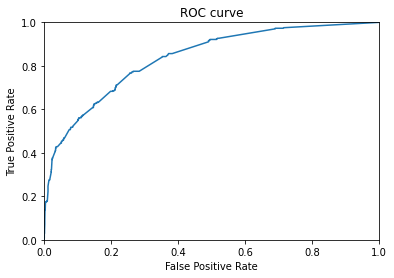

,accuracy,recall_score,precision,f1_score,r2_score,roc_auc,confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score
0,0.853766,0.428,0.742,0.543,0.096,0.695,"[[1395, 55], [211, 158]]",0.146,0.146,0.688355


In [32]:
display(full_score_report(model=rfr_model,features=features_valid,target=target_valid, predictions=rfr_predict_valid))

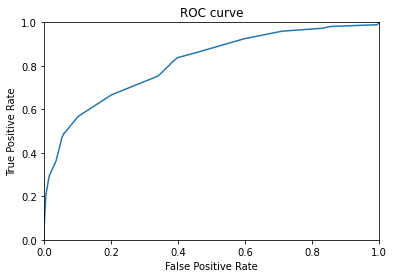

,accuracy,recall_score,precision,f1_score,r2_score,roc_auc,confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score
0,0.771853,0.667,0.457,0.542,-0.411,0.733,"[[1158, 292], [123, 246]]",0.228,0.228,0.734126


In [33]:
display(full_score_report(model=dtc_model, features=features_valid, target=target_valid, predictions=dtc_predict_valid))

Initial valid f1 scores for both models are right at 0.54. However, both models got these scores in opposite ways. The decision tree classifier had high recall score and low precision which means it needs higher precision which calls for a need of downsampling to increase precision. However, the random forest has low recall and high precision. This model would benefit more from upsampling to increase recall. I will be experimenting with upsampling and downsampling both models though to find all possible model improvements since 0.54 is still not a great score regardless.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you trained a couple of models without taking the imbalance into account first. Nice analysis of the results!

</div>

#### Upsampling

In [34]:
recall_scores = []
precision_scores = []
best_up_samp_rfr = 0
best_up_samp_dtc = 0
best_f1_rfr = 0
best_f1_dtc = 0

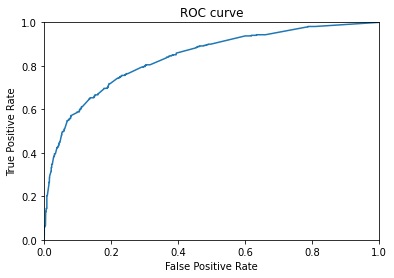

,accuracy,recall_score,precision,f1_score,r2_score,roc_auc,confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score
0,0.847719,0.558,0.644,0.598,0.058,0.74,"[[1336, 114], [163, 206]]",0.152,0.152,0.723705


'Random Forest Upsample Repetitions:9'

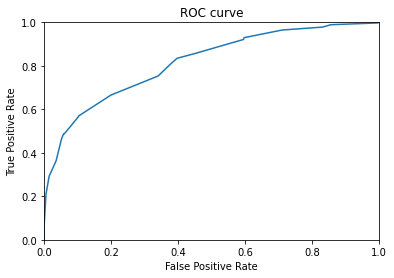

,accuracy,recall_score,precision,f1_score,r2_score,roc_auc,confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score
0,0.772402,0.667,0.458,0.543,-0.407,0.733,"[[1159, 291], [123, 246]]",0.228,0.228,0.729683


'Decision Tree Upsample Repetitions:9'

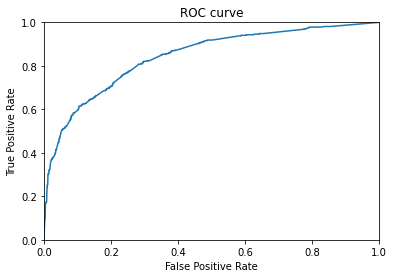

,accuracy,recall_score,precision,f1_score,r2_score,roc_auc,confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score
0,0.84497,0.575,0.629,0.601,0.041,0.744,"[[1325, 125], [157, 212]]",0.155,0.155,0.73298


'Random Forest Upsample Repetitions:12'

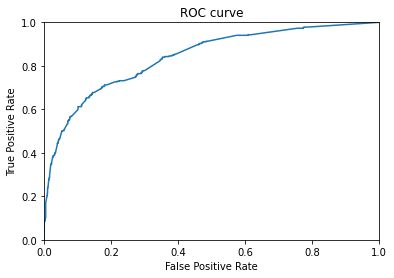

,accuracy,recall_score,precision,f1_score,r2_score,roc_auc,confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score
0,0.849918,0.566,0.649,0.605,0.072,0.744,"[[1337, 113], [160, 209]]",0.15,0.15,0.733623


'Random Forest Upsample Repetitions:20'

In [35]:
for upsamp in range(1,21,1):
    rfr_model_up = RandomForestClassifier(**rfr_model.best_params_)
    dtc_model_up = DecisionTreeClassifier(**dtc_model.best_params_)
    features_up_sample, target_up_sample = upsample(
    features_train, target_train, upsamp)

    rfr_model_up.fit(features_up_sample, target_up_sample)
    dtc_model_up.fit(features_up_sample, target_up_sample)
    rfr_predict_valid = rfr_model_up.predict(features_valid)
    dtc_predict_valid = dtc_model_up.predict(features_valid)

    if(((f1_score(target_valid,rfr_predict_valid) > best_f1_rfr) and (f1_score(target_valid,rfr_predict_valid) > 0.59)) or ((f1_score(target_valid,dtc_predict_valid) > best_f1_dtc) and (f1_score(target_valid,dtc_predict_valid) > 0.59))):
        clear_output(wait=True)
        if(f1_score(target_valid,rfr_predict_valid) > best_f1_rfr):
            best_f1_rfr = f1_score(target_valid,rfr_predict_valid)        
            display(full_score_report(model=rfr_model_up, features=features_valid, target=target_valid, predictions=rfr_predict_valid))
            display('Random Forest Upsample Repetitions:' + str(upsamp))
            best_up_samp_rfr = upsamp
        if(f1_score(target_valid,dtc_predict_valid) > best_f1_dtc):
            best_f1_dtc = f1_score(target_valid,dtc_predict_valid)
            display(full_score_report(model=dtc_model_up, features=features_valid, target=target_valid, predictions=dtc_predict_valid))
            display('Decision Tree Upsample Repetitions:' + str(upsamp))
            best_up_samp_dtc = upsamp

In [36]:
display('Best upsample repetitions for Random Forest:' + str(best_up_samp_rfr))

'Best upsample repetitions for Random Forest:20'

In [37]:
display('Best upsample repetitions for Decision Tree:' + str(best_up_samp_dtc))

'Best upsample repetitions for Decision Tree:9'

In [38]:
rfr_test = RandomForestClassifier(**rfr_model.best_params_)
dtc_test = DecisionTreeClassifier(**dtc_model.best_params_)

In [39]:
features_up_sample_rfr, target_up_sample_rfr = upsample(
    features_train, target_train, best_up_samp_rfr)

In [40]:
features_up_sample_dtc, target_up_sample_dtc = upsample(
    features_train, target_train, best_up_samp_dtc)

In [41]:
rfr_test.fit(features_up_sample_rfr, target_up_sample_rfr)
rfr_predict_test = rfr_test.predict(features_test)

In [42]:
dtc_test.fit(features_up_sample_dtc, target_up_sample_dtc)
dtc_predict_test = dtc_test.predict(features_test)

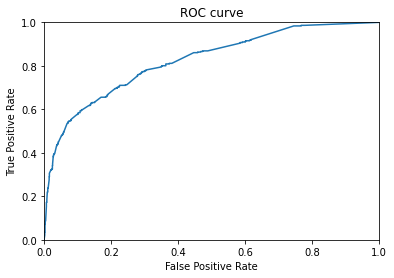

,accuracy,recall_score,precision,f1_score,r2_score,roc_auc,confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score
0,0.845435,0.546,0.635,0.587,0.039,0.734,"[[1337, 115], [166, 200]]",0.155,0.155,0.733623


In [43]:
display(full_score_report(model=rfr_test, features=features_test, target=target_test, predictions=rfr_predict_test))

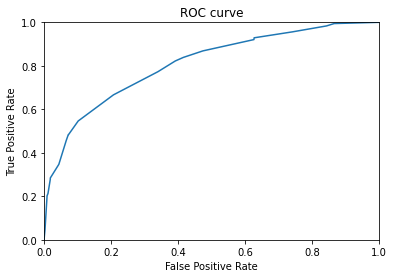

,accuracy,recall_score,precision,f1_score,r2_score,roc_auc,confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score
0,0.767327,0.667,0.448,0.536,-0.447,0.73,"[[1151, 301], [122, 244]]",0.233,0.233,0.729683


In [44]:
display(full_score_report(model=dtc_test, features=features_test, target=target_test, predictions=dtc_predict_test))

After completing the upsampling, the Decision Tree Classifier had an f1 test score of 0.536 which occured with high recall of 0.667 and low precision of 0.448. This means this model is good at having fewer false negatives, but has many false positives. The Random Forest Classifier's f1 test score was 0.587 with a recall score of 0.546 and a precision score of 0.635. This means the random forest has more false negatives, and fewer false positives. In final, the decision needs downsampling to improve precision, but the random forest would likely need slightly higher upsampling to increase recall.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Upsampling was applied correctly! It's nice that you tuned the upsampling factor using the validation set!

</div>

#### Downsampling

In [45]:
recall_scores = []
precision_scores = []
best_f1_rfr = 0
best_f1_dtc = 0
best_down_samp_rfr = 0
best_down_samp_dtc = 0
downsamples = [float(i) / 1000 for i in range(0, 1001, 2)]

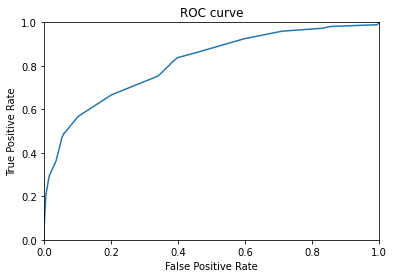

,accuracy,recall_score,precision,f1_score,r2_score,roc_auc,confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score
0,0.827927,0.637,0.568,0.6,-0.064,0.757,"[[1271, 179], [134, 235]]",0.172,0.172,0.734126


'Decision Tree Downsample Fraction:0.46'

In [46]:
for downsamp in downsamples:
    rfr_model_down = RandomForestClassifier(**rfr_model.best_params_)
    dtc_model_down = DecisionTreeClassifier(**dtc_model.best_params_)
    
    features_down_sample, target_down_sample = downsample(
    features_train, target_train, downsamp)
    
    rfr_model_down.fit(features_down_sample, target_down_sample)
    rfr_predict_valid = rfr_model_down.predict(features_valid)
    
    dtc_model_down.fit(features_down_sample, target_down_sample)
    dtc_predict_valid = dtc_model_down.predict(features_valid)

    if(((f1_score(target_valid,rfr_predict_valid) > best_f1_rfr) and (f1_score(target_valid,rfr_predict_valid) > 0.59)) or ((f1_score(target_valid,dtc_predict_valid) > best_f1_dtc) and (f1_score(target_valid,dtc_predict_valid) > 0.59))):
        clear_output(wait=True)
        if(f1_score(target_valid,rfr_predict_valid) > best_f1_rfr):
            best_f1_rfr = f1_score(target_valid,rfr_predict_valid)        
            display(full_score_report(model=rfr_model, features=features_valid, target=target_valid, predictions=rfr_predict_valid))
            display('Random Forest Downsample Fraction:' + str(downsamp))
            best_down_samp_rfr = downsamp
        if(f1_score(target_valid,dtc_predict_valid) > best_f1_dtc):
            best_f1_dtc = f1_score(target_valid,dtc_predict_valid)
            display(full_score_report(model=dtc_model, features=features_valid, target=target_valid, predictions=dtc_predict_valid))
            display('Decision Tree Downsample Fraction:' + str(downsamp))
            best_down_samp_dtc = downsamp

In [47]:
rfr_test = RandomForestClassifier(**rfr_model.best_params_)
dtc_test = DecisionTreeClassifier(**dtc_model.best_params_)

In [48]:
features_down_sample_rfr, target_down_sample_rfr = downsample(
    features_train, target_train, best_down_samp_rfr)

In [49]:
features_down_sample_dtc, target_down_sample_dtc = downsample(
    features_train, target_train, best_down_samp_dtc)

In [50]:
rfr_test.fit(features_down_sample_rfr, target_down_sample_rfr)
rfr_predict_test = rfr_test.predict(features_test)

In [51]:
dtc_test.fit(features_down_sample_dtc, target_down_sample_dtc)
dtc_predict_test = dtc_test.predict(features_test)

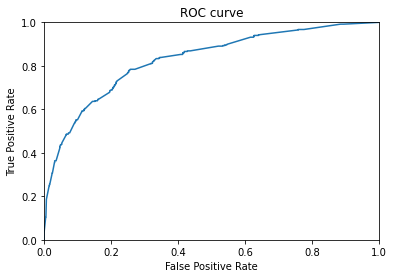

,accuracy,recall_score,precision,f1_score,r2_score,roc_auc,confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score
0,0.823432,0.596,0.558,0.576,-0.098,0.738,"[[1279, 173], [148, 218]]",0.177,0.177,0.738241


In [52]:
display(full_score_report(model=rfr_test, features=features_test, target=target_test, predictions=rfr_predict_test))

In [53]:
display(f1_score(target_test, dtc_predict_test))

0.5815423514538559

In [54]:
display(best_down_samp_dtc)

0.46

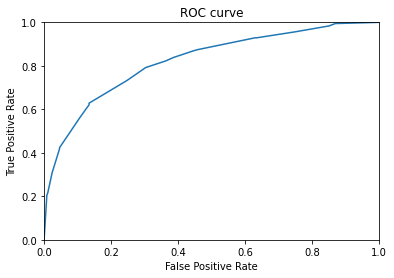

,accuracy,recall_score,precision,f1_score,r2_score,roc_auc,confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score
0,0.817932,0.628,0.541,0.582,-0.132,0.747,"[[1257, 195], [136, 230]]",0.182,0.182,0.747059


In [55]:
display(full_score_report(model=dtc_test, features=features_test, target=target_test, predictions=dtc_predict_test))

After completing the downsampling, the Decision Tree Classifier had an f1 test score of 0.582 which occured with high recall of 0.628 and low precision of 0.541. This means this model is good at having fewer false negatives, but has more false positives. The Random Forest Classifier's f1 test score was 0.576 with a recall score of 0.596 and a precision score of 0.558. This means the random forest is more balanced, but is slightly more common to have false positives, and fewer false negatives, but not by a lot. In final, both models would likely need higher upsampling to increase recall.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Downsampling was applied successfully!
    
    

</div>

<div class="alert alert-warning">
<b>Reviewer's comment</b>

A couple of suggestions:
    
1. It looks like you tuned the models' hyperparameters only without any balancing. If you tune the model's hyperparameters with upsampling/downsampling, you might achieve even better results. Though you'd have to take care not to do cross-validation on already upsampled/downsampled data and instead apply it in each fold separately (e.g. using imblearn library with its [pipelines](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline))
    
2. I would leave the test set only for the final model evaluation, and compare the models using different balancing techniques using the validation set to avoid possibly overly optimistic test set score.

</div>